<a href="https://colab.research.google.com/github/AmulyaMat/Breast-Cancer-MRI-Classification/blob/main/BreastMRI_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Cancer Reccurance risk for Real and Synthetic Breast MRI**

### 1.   Mounting files from colab



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Installing Pytorch image models and importing libraries

In [3]:
!pip install timm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [29]:
import timm
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn, optim

### 3.   Creating Data Loader and processing data

Excel file containing Breast MRI Cancer information

In [36]:
clinical_excel = pd.read_excel('/content/drive/MyDrive/VLR Project/Clinical_and_Other_Features.xlsx', header = 1)

In [37]:
clinical_excel

,Patient ID,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),...,Therapeutic or Prophylactic Oophorectomy as part of Endocrine Therapy,Neoadjuvant Anti-Her2 Neu Therapy,Adjuvant Anti-Her2 Neu Therapy,Received Neoadjuvant Therapy or Not,Pathologic response to Neoadjuvant therapy: Pathologic stage (T) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (N) following neoadjuvant therapy,Pathologic response to Neoadjuvant therapy: Pathologic stage (M) following neoadjuvant therapy,Overall Near-complete Response: Stricter Definition,Overall Near-complete Response: Looser Definition,Near-complete Response (Graded Measure)
0,NaN,NaN,"GE MEDICAL SYSTEMS=0, MPTronic software=1, SIE...","Avanto=0, Optima MR450w=1, SIGNA EXCITE=2, SIG...","FAST_GEMS\SAT_GEMS\ACC_GEMS\PFP\FS=0,FAST_GEMS...","1.494=0,1.5=1,2.8936=2,3=3","FFP=0,HFP=1",NaN,"GADAVIST=0,MAGNEVIST=1,MMAGNEVIST=2,MULTIHANCE...","6=0,7=1,8=2,9=3,10=4,11=5,11.88=6,12=7,13=8,13...",...,"{0 = no, 1 = yes, NP = not pertinent}","{0 = no, 1 = yes}","{0 = no, 1 = yes}","{1 = yes, 2 = no, NA = not applicable}",{ -1 = TX; 0 = T0; 1 = T1; 2 = T2; 3 = T3;...,{ -1 = NX; 0 = N0; 1 = N1; 2 = N2; 3 = N3...,{ -1 = MX; 0 = M0; 1 = M1; NA = not applica...,"{0 = not complete or near-complete, 1 = comple...","{0 = not complete or near-complete, 1 = comple...",{0 = Not complete or near-complete; 1 = Compl...
1,Breast_MRI_001,6.0,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,...,1,1,1,1,1,-1,-1,0,0,0
2,Breast_MRI_002,12.0,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,...,0,0,0,1,NaN,NaN,NaN,2,2,4
3,Breast_MRI_003,10.0,0,3,2,3,0,174.658 X 228.317 X 88.4878,1,NaN,...,0,0,0,1,1,1,-1,0,0,0
4,Breast_MRI_004,18.0,0,4,1,1,0,188.148 X 194.282 X 94.1832,1,NaN,...,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,Breast_MRI_918,6.0,0,4,1,1,0,179.537 X 165.877 X 100,4,NaN,...,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
919,Breast_MRI_919,24.0,0,4,1,1,0,172.595 X 192.108 X 130.246,4,NaN,...,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
920,Breast_MRI_920,21.0,2,0,5,1,1,-173.6078 X -147.4121 X 78.5315,3,5,...,0,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN
921,Breast_MRI_921,21.0,0,1,1,1,0,206.292 X 221.499 X 118.632,3,NaN,...,0,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
clinical_excel = clinical_excel[1:]
labels = clinical_excel['Recurrence event(s)']
labels = labels.fillna(0).astype(int)

In [39]:
labels_df = pd.DataFrame(labels)
labels_df

,Recurrence event(s)
1,0
2,0
3,0
4,0
5,0
...,...
918,0
919,0
920,0
921,0


Creating Data Loader

In [55]:
def load_and_preprocess_image(path):
    image = Image.open(path).convert('L')  # Convert to grayscale
    image = image.convert('RGB')  # Convert grayscale to RGB by duplicating channels
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization for RGB
    ])
    return transform(image)

class TemporalBreastMRIDataset(Dataset):
    def __init__(self, root_dir, labels_df):
        # Assuming the subdirectories are named as follows
        self.subdirs = ['pre', 'post_1', 'post_2']
        self.root_dir = root_dir
        # This will store a list of tuples (image_paths, label)
        self.samples = []

        # Reset index of the labels DataFrame to ensure alignment with images
        labels_df = labels_df.reset_index(drop=True)
        self.labels = labels_df['Recurrence event(s)'].values

        # Load all image paths and corresponding labels
        # Assumes image filenames are consistent across subdirectories and labels
        image_filenames = sorted(os.listdir(os.path.join(root_dir, self.subdirs[0])))
        for idx, filename in enumerate(image_filenames):
            if filename.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff')):
                image_paths = [os.path.join(root_dir, subdir, filename) for subdir in self.subdirs]
                label = self.labels[idx]
                self.samples.append((image_paths, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_paths, label = self.samples[idx]
        images = [load_and_preprocess_image(image_path) for image_path in image_paths]
        images_tensor = torch.stack(images)  # Stacks a list of Tensors along a new dimension
        return images_tensor, label

# Example usage
root_dir = '/content/drive/MyDrive/VLR Project'
#labels = pd.DataFrame({'Recurrence event(s)': [0, 1, 0, 1]})  # Example DataFrame with labels

dataset = TemporalBreastMRIDataset(root_dir, labels_df)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

In [56]:
for image, label in train_dataloader:
  print(image.shape)
  print(label)

torch.Size([1, 3, 3, 224, 224])
tensor([0])
torch.Size([1, 3, 3, 224, 224])
tensor([0])
torch.Size([1, 3, 3, 224, 224])
tensor([0])
torch.Size([1, 3, 3, 224, 224])
tensor([0])
torch.Size([1, 3, 3, 224, 224])
tensor([0])


KeyboardInterrupt: 

### 4. Visualizing images

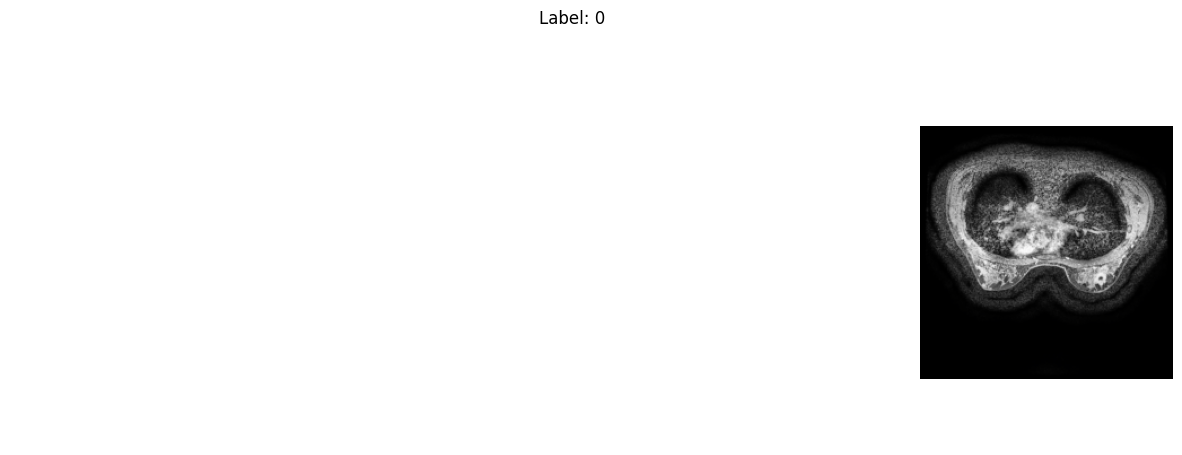

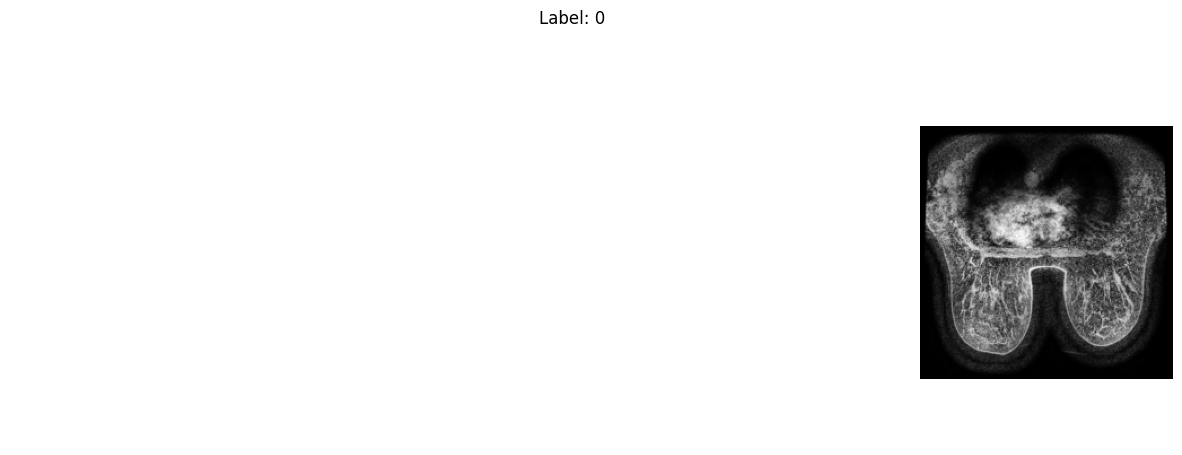

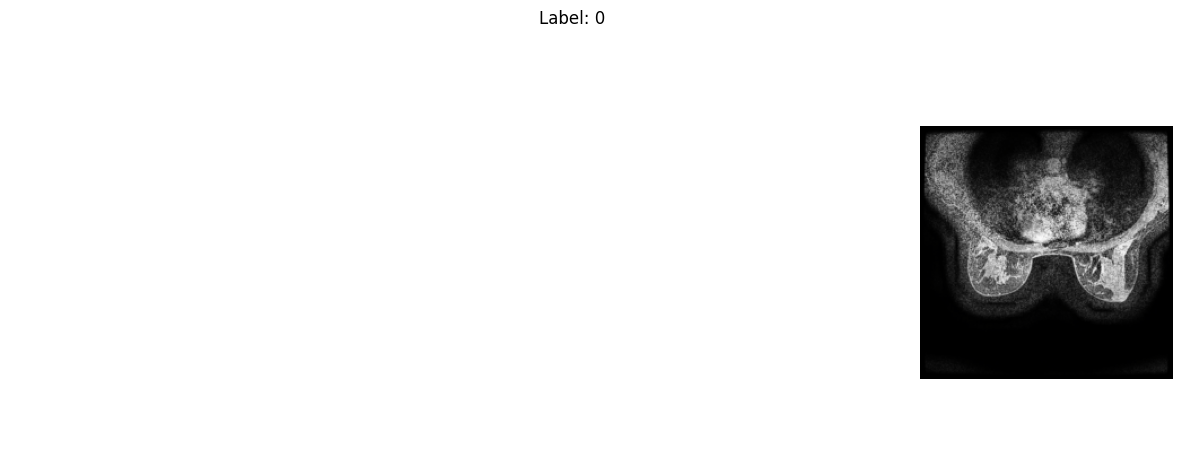

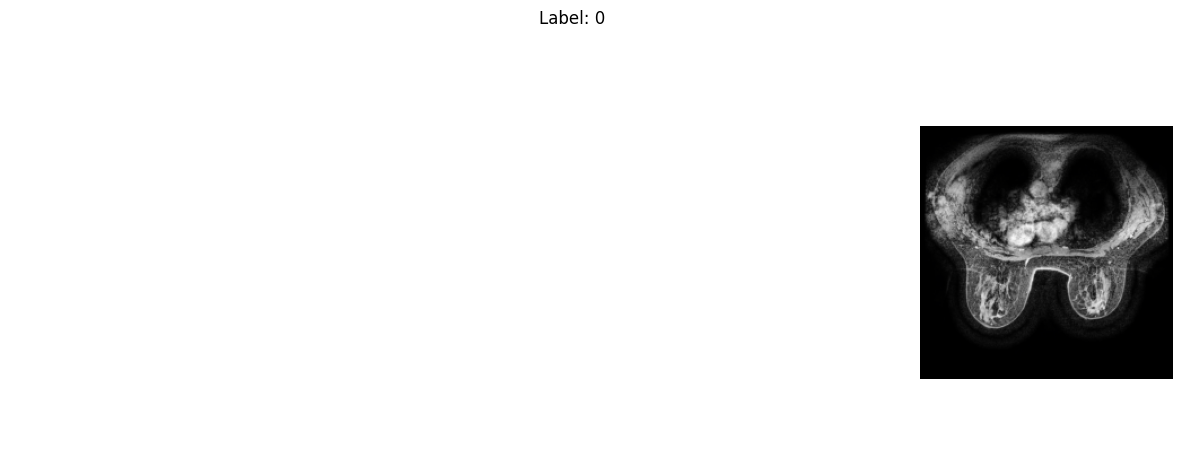

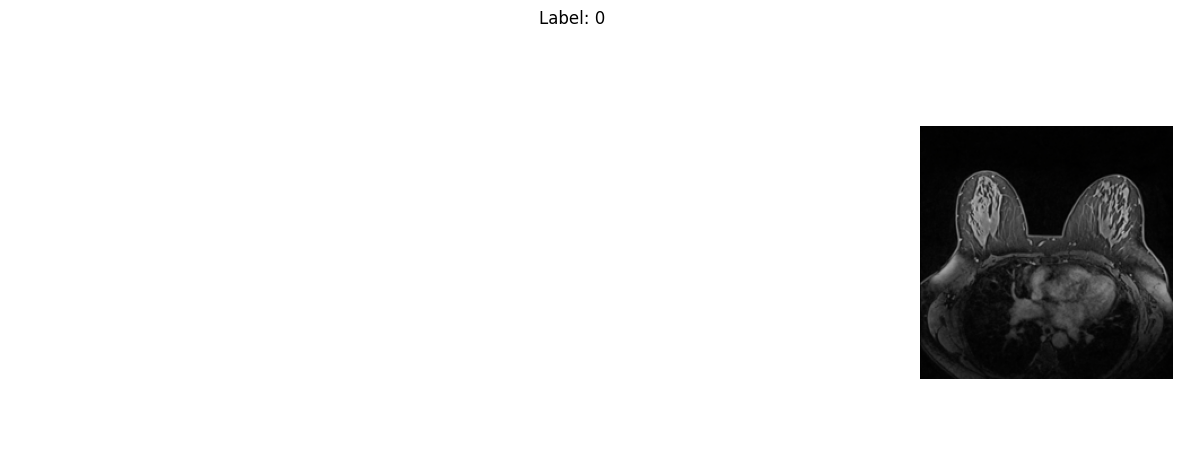

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Function to convert a Tensor to a NumPy array for plotting
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Example for iterating over the DataLoader
for i, (images, label) in enumerate(train_dataloader):
    # Check if we have already displayed 5 sets of images
    if i >= 5:
        break

    # Remove batch dimension only if batch_size=1
    if images.shape[0] == 1:
        images = images.squeeze(0)

    fig, axs = plt.subplots(1, images.shape[0], figsize=(15, 5))
    for j in range(images.shape[0]):
        img = images[j]
        ax = axs[j] if images.shape[0] > 1 else axs
        imshow(img.cpu())
        ax.axis('off')
    plt.suptitle(f'Label: {label.item()}')
    plt.show()


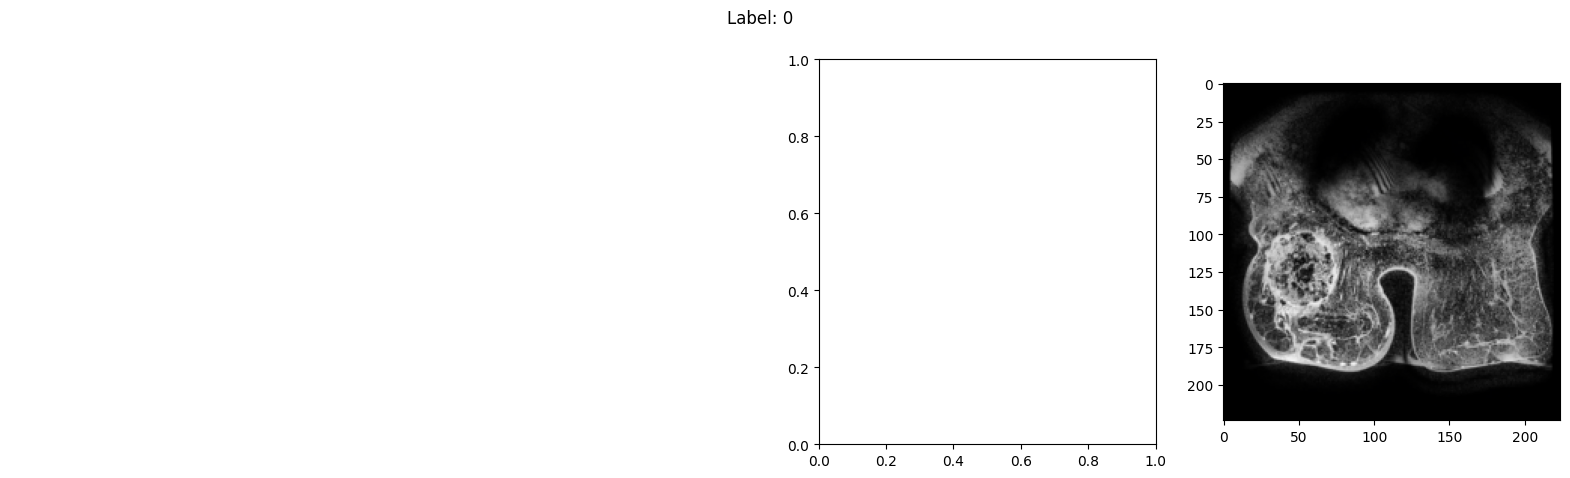

In [66]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to convert a Tensor to a NumPy array for plotting
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# Example for iterating over the DataLoader
for i, (images, label) in enumerate(train_dataloader):
    # Check if we have already displayed the first batch of 4 sets of images
    if i >= 1:  # Since you mentioned only the first 4, we break after the first batch
        break

    # Remove batch dimension only if batch_size=1, and display the images
    images = images.squeeze(0)  # Assume images is of shape [1, 4, 3, 224, 224]

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # Prepare a row of 4 images
    for j in range(2):  # Assuming there are exactly 4 images per batch
        img = images[j]
        ax = axs[j]
        imshow(img.cpu())  # Make sure to move the tensor to 'cpu' if it's on 'cuda'
        ax.axis('off')
    plt.suptitle(f'Label: {label.item()}')
    plt.show()


### 5. Creating & Implementing Vision Transformer Model (from Hugging Face)

In [44]:
print(timm.list_models('vit*'))


['vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch14_reg4_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil', 'vit_base_patch16_384', 'vit_base_patch16_clip_224', 'vit_base_patch16_clip_384', 'vit_base_patch16_clip_quickgelu_224', 'vit_base_patch16_gap_224', 'vit_base_patch16_plus_240', 'vit_base_patch16_reg4_gap_256', 'vit_base_patch16_rpn_224', 'vit_base_patch16_siglip_224', 'vit_base_patch16_siglip_256', 'vit_base_patch16_siglip_384', 'vit_base_patch16_siglip_512', 'vit_base_patch16_xp_224', 'vit_base_patch32_224', 'vit_base_patch32_384', 'vit_base_patch32_clip_224', 'vit_base_patch32_clip_256', 'vit_base_patch32_clip_384', 'vit_base_patch32_clip_448', 'vit_base_patch32_clip_quickgelu_224', 'vit_base_patch32_plus_256', 'vit_base_r26_s32_224', 'vit_base_r50_s16_224', 'vit_base_r50_s16_384', 'vit_base_resnet26d_224', 'vit_base_resnet50d_224', 'vit_giant_patch14_224', 'vit_giant_patch14_clip_224', 'vit_giant_patch14_dinov2', 'vit_g

In [47]:
vit_model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

Train model

In [57]:
def train_model(dataloader, model, loss_fn, optimizer, epochs):
    for epoch in range(epochs):
        for image_set, label in dataloader:
            # image_set is of shape [1, 4, 3, 224, 224], so we reshape it to [4, 3, 224, 224]
            image_set = image_set.squeeze(0)  # Now of shape [4, 3, 224, 224]

            for image in image_set:
                # Add a batch dimension so it's suitable for the model, shape becomes [1, 3, 224, 224]
                image = image.unsqueeze(0).to(device)
                label = label.to(device)

                # Forward pass
                output = model(image)
                loss = loss_fn(output, label)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Start training
train_model(train_dataloader, vit_model, loss_fn, optimizer, epochs=20)


Epoch 1, Loss: 0.01932939887046814
Epoch 2, Loss: 0.12991751730442047
Epoch 3, Loss: 3.2541606426239014
Epoch 4, Loss: 0.08109812438488007
Epoch 5, Loss: 0.0788750946521759
Epoch 6, Loss: 0.1881186068058014
Epoch 7, Loss: 0.06093120947480202
Epoch 8, Loss: 0.09000793844461441
Epoch 9, Loss: 0.10448867827653885
Epoch 10, Loss: 0.008538997732102871
Epoch 11, Loss: 0.05472227931022644
Epoch 12, Loss: 0.07155103981494904
Epoch 13, Loss: 0.0179843008518219
Epoch 14, Loss: 0.1934153437614441
Epoch 15, Loss: 0.07245177030563354
Epoch 16, Loss: 0.1139264702796936
Epoch 17, Loss: 0.11659511178731918
Epoch 18, Loss: 0.150324285030365
Epoch 19, Loss: 0.07699452340602875
Epoch 20, Loss: 0.023436322808265686


### 6. Using testing data

Use testing data

In [59]:
class TestImageDataset(Dataset):
    def __init__(self, directory, labels_df):
        self.directory = directory
        self.image_paths = [os.path.join(directory, f) for f in sorted(os.listdir(directory)) if f.lower().endswith(('png', 'jpg', 'jpeg', 'tif', 'tiff'))]
        self.labels = labels_df['Recurrence event(s)'].values  # Assumes the DataFrame column is named 'Label'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = load_and_preprocess_image(image_path)
        label = self.labels[idx]  # Assumes the order of labels corresponds to the order of files
        return image, label


directory = '/content/drive/MyDrive/VLR Project/post_4'
dataset = TestImageDataset(directory, labels_df)
test_loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)

In [61]:
def evaluate_model(dataloader, model):
    model.eval()  # Set the model to evaluation mode
    total, correct = 0, 0
    predictions, true_labels = [], []

    with torch.no_grad():  # No gradients needed for evaluation, which saves memory and computations
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, predictions, true_labels

accuracy, predictions, true_labels = evaluate_model(test_loader, vit_model)
print(f"Accuracy on test data: {accuracy*100:.2f}%")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy on test data: 89.38%


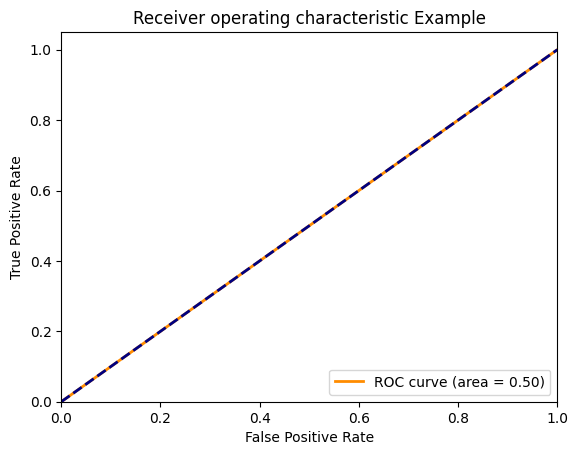

In [63]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test are the true labels and y_scores are the probability estimates from the model
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic Example')
plt.legend(loc="lower right")
plt.show()

Alternate idea: https://github.com/haarburger/multi-scale-curriculum/tree/master

In [ ]:
!git clone https://github.com/haarburger/multi-scale-curriculum.git

Cloning into 'multi-scale-curriculum'...
remote: Enumerating objects: 90, done.
remote: Total 90 (delta 0), reused 0 (delta 0), pack-reused 90
Receiving objects: 100% (90/90), 290.07 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
%cd multi-scale-curriculum
!pip install -e .

/content/multi-scale-curriculum/multi-scale-curriculum/multi-scale-curriculum
Obtaining file:///content/multi-scale-curriculum/multi-scale-curriculum/multi-scale-curriculum
  Preparing metadata (setup.py) ... done
  Using cached delira-0.4.1-py3-none-any.whl
  Using cached jupyter-1.0.0-py2.py3-none-any.whl.metadata (995 bytes)
  Using cached SimpleITK-2.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
  Using cached pylint-3.1.0-py3-none-any.whl.metadata (12 kB)
  Using cached visdom-0.2.4-py3-none-any.whl
  Using cached trixi_slim-0.1.2.2-py3-none-any.whl.metadata (8.4 kB)
  Using cached batchgenerators-0.25-py3-none-any.whl
  Using cached nested_lookup-0.2.25-py3-none-any.whl
  Using cached trixi-0.1.2.2-py3-none-any.whl.metadata (8.7 kB)
  Using cached unittest2-1.1.0-py2.py3-none-any.whl.metadata (15 kB)
  Using cached qtconsole-5.5.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.met

In [ ]:
!pip install --upgrade pip setuptools wheel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 894.6/894.6 kB 42.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


In [ ]:
# generate dummy data
!python /content/multi-scale-curriculum/experiments/example/generate_data.py


Processing id 0 of type square
/content/multi-scale-curriculum/experiments/example/generate_data.py:32: ComplexWarning: Casting complex values to real discards the imaginary part
  mask = np.zeros_like(patch).astype(np.uint8)
/content/multi-scale-curriculum/experiments/example/generate_data.py:55: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  patch[mask.astype(np.bool)] += offset
Traceback (most recent call last):
  File "/content/multi-scale-curriculum/experiments/example/generate_data.py", line 78, in <module>
    create_single_sample(*c)
  File "/content/multi-scale-curriculum/experiments/example/generate_data.py", line 55, in create_single_sample
    patch[mask.astype(np.bool)] += offset
  File "/usr/local/lib/python3.10/dist-packages/numpy/__init__.py", line 319, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`

In [ ]:
!rm -rf /content/mscl